<a href="https://colab.research.google.com/github/Sriya0001/TripTales/blob/main/aiml_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d elmehdi12/keratoconus-detection
!unzip keratoconus-detection.zip -d /content/keratoconus_dataset


Dataset URL: https://www.kaggle.com/datasets/elmehdi12/keratoconus-detection
License(s): other
keratoconus-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  keratoconus-detection.zip
replace /content/keratoconus_dataset/Independent Test Set/Independent Test Set/Keratoconus/case1/KCN_1_CT_A.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install scikit-image opencv-python scikit-learn xgboost imbalanced-learn


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog, local_binary_pattern

try:
    from skimage.feature import graycomatrix, graycoprops
except ImportError:
    from skimage.feature import greycomatrix as graycomatrix
    from skimage.feature import greycoprops as graycoprops

# sklearn + xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


import joblib


In [ ]:
def extract_hog(gray):
    return hog(gray, orientations=9, pixels_per_cell=(16,16),
               cells_per_block=(2,2), block_norm="L2-Hys", feature_vector=True)

def extract_lbp(gray):
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 8+3), range=(0, 8+2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_glcm(gray):
    gray_small = cv2.resize(gray, (64,64))
    glcm = graycomatrix(gray_small, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    feats = []
    for p in ["contrast","correlation","energy","homogeneity"]:
        feats.extend(graycoprops(glcm, p).flatten())
    return np.array(feats)

def color_histogram(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = []
    for i in range(3):
        h = cv2.calcHist([hsv],[i],None,[16],[0,256]).flatten()
        hist.extend(h)
    hist = np.array(hist)
    hist /= (hist.sum()+1e-6)
    return hist

def extract_features(path, resize=(224,224)):
    img = cv2.imread(path)
    img = cv2.resize(img, resize)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f1 = extract_hog(gray)
    f2 = extract_lbp(gray)
    f3 = extract_glcm(gray)
    f4 = color_histogram(img)
    return np.hstack([f1,f2,f3,f4])


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

def build_complete_dataset(base_dir):
    X, y = [], []
    # Define the true classes we want to find
    classes = ['Normal', 'Keratoconus', 'Suspect']
    class_map = {name: i for i, name in enumerate(classes)}

    print(f"Searching for classes: {classes}")

    # Find all image paths and associate them with the correct label
    for cls_name in classes:
        search_path = os.path.join(base_dir, "**", cls_name)
        class_dirs = glob(search_path, recursive=True)
        image_count = 0
        for class_dir in class_dirs:
            img_paths = glob(os.path.join(class_dir, "**", "*.*"), recursive=True)
            img_paths = [p for p in img_paths if p.lower().endswith((".jpg",".jpeg",".png"))]
            image_count += len(img_paths)

            for img_path in tqdm(img_paths, desc=f"Processing {os.path.basename(class_dir)} ({cls_name})"):
                try:
                    feats = extract_features(img_path)
                    X.append(feats)
                    y.append(class_map[cls_name])
                except Exception as e:
                    print(f"Skipped {img_path}: {e}")
        print(f"Found {image_count} images for class '{cls_name}'")

    return np.array(X), np.array(y), classes

X, y, classes = build_complete_dataset("/content/keratoconus_dataset")
print("\nDataset shape:", X.shape, y.shape)

Searching for classes: ['Normal', 'Keratoconus', 'Suspect']


Processing Normal (Normal): 100%|██████████| 1050/1050 [00:32<00:00, 31.82it/s]


Found 1400 images for class 'Normal'


Processing Keratoconus (Keratoconus): 100%|██████████| 1050/1050 [00:32<00:00, 32.06it/s]


Found 1400 images for class 'Keratoconus'


Processing Suspect (Suspect): 100%|██████████| 861/861 [00:26<00:00, 32.13it/s]


Found 1211 images for class 'Suspect'

Dataset shape: (4011, 6146) (4011,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("After PCA:", X_train_pca.shape)


After PCA: (3008, 1126)



=== SVM ===
Accuracy: 0.7278165503489531
              precision    recall  f1-score   support

      Normal       0.68      0.78      0.73       350
 Keratoconus       0.92      0.82      0.86       350
     Suspect       0.59      0.57      0.58       303

    accuracy                           0.73      1003
   macro avg       0.73      0.72      0.72      1003
weighted avg       0.74      0.73      0.73      1003



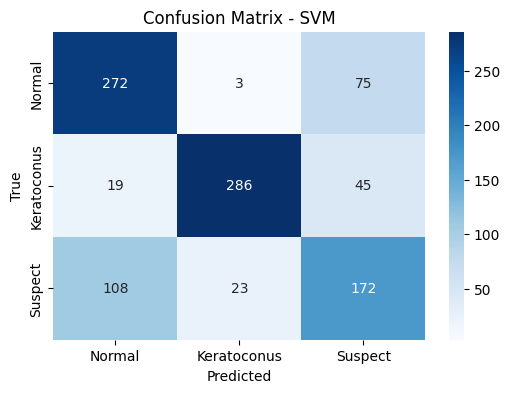


=== RandomForest ===
Accuracy: 0.5952143569292123
              precision    recall  f1-score   support

      Normal       0.52      0.80      0.63       350
 Keratoconus       0.74      0.72      0.73       350
     Suspect       0.53      0.21      0.30       303

    accuracy                           0.60      1003
   macro avg       0.59      0.58      0.55      1003
weighted avg       0.60      0.60      0.57      1003



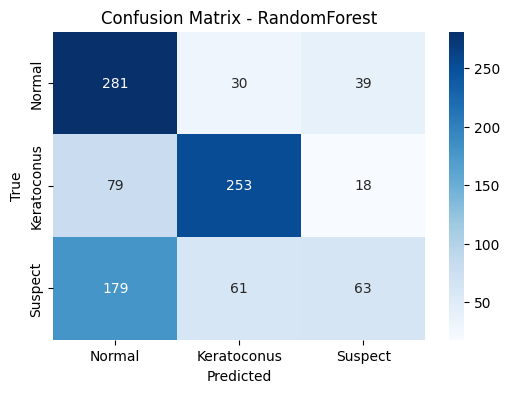

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:02:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.646061814556331
              precision    recall  f1-score   support

      Normal       0.58      0.75      0.66       350
 Keratoconus       0.83      0.76      0.79       350
     Suspect       0.52      0.40      0.45       303

    accuracy                           0.65      1003
   macro avg       0.64      0.63      0.63      1003
weighted avg       0.65      0.65      0.64      1003



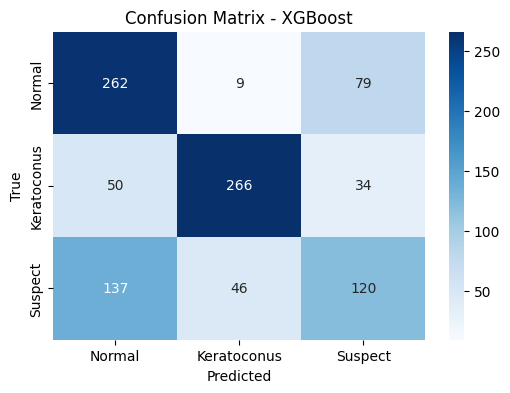


Summary of Accuracies:
SVM: 0.7278
RandomForest: 0.5952
XGBoost: 0.6461


In [ ]:
svm = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)
rf  = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
xg  = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)

results = {}

def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

for name, clf in [("SVM", svm), ("RandomForest", rf), ("XGBoost", xg)]:
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, target_names=classes))
    plot_confusion(y_test, y_pred, name)

print("\nSummary of Accuracies:")
for k,v in results.items():
    print(f"{k}: {v:.4f}")


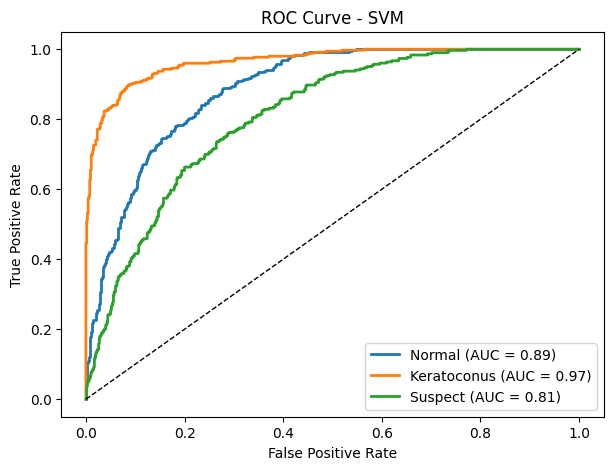

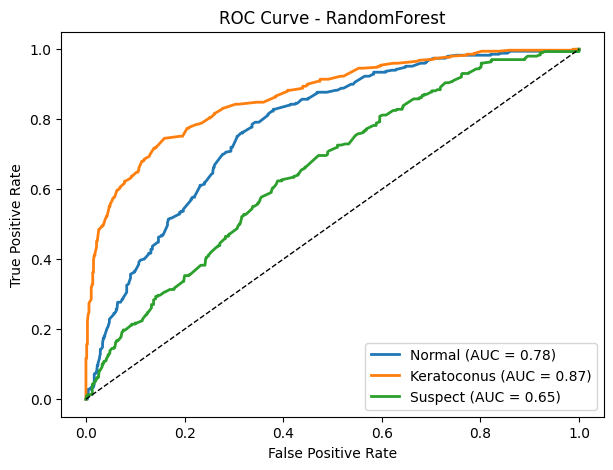

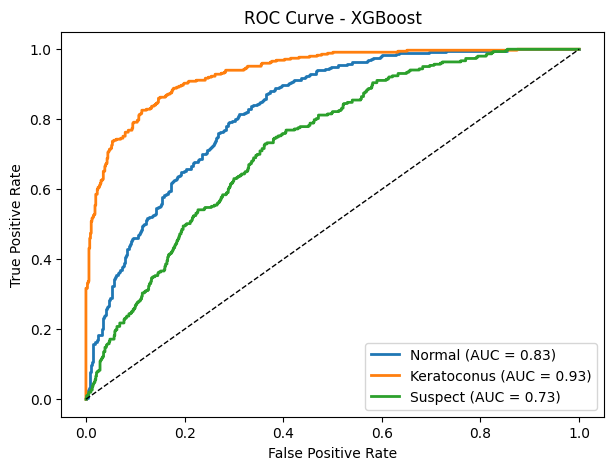

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for One-vs-Rest ROC
y_test_bin = label_binarize(y_test, classes=np.arange(len(classes)))
n_classes = y_test_bin.shape[1]

def plot_roc_curves(model, X_test, y_test_bin, model_name):
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(7,5))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

# Generate ROC curves for each model
for name, clf in [("SVM", svm), ("RandomForest", rf), ("XGBoost", xg)]:
    plot_roc_curves(clf, X_test_pca, y_test_bin, name)


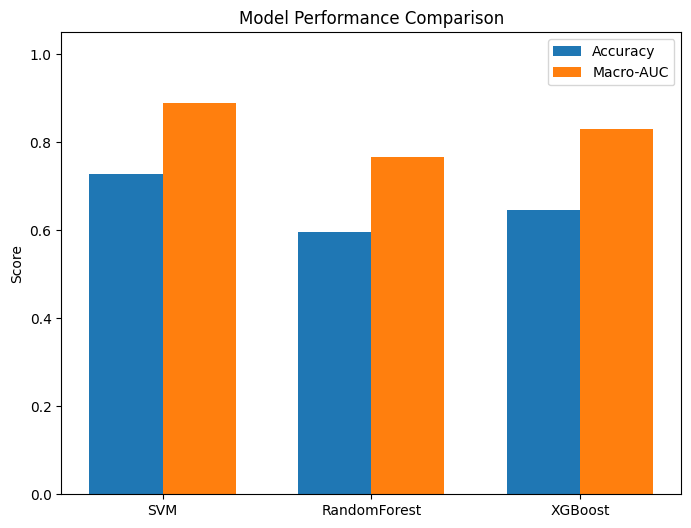

Summary Table:
SVM: Accuracy=0.7278, Macro-AUC=0.8882
RandomForest: Accuracy=0.5952, Macro-AUC=0.7656
XGBoost: Accuracy=0.6461, Macro-AUC=0.8309


In [ ]:
from sklearn.metrics import roc_auc_score

model_metrics = {}

for name, clf in [("SVM", svm), ("RandomForest", rf), ("XGBoost", xg)]:
    y_score = clf.predict_proba(X_test_pca)

    if y_score.shape[1] == 2:
        # Binary classification
        macro_auc = roc_auc_score(y_test, y_score[:,1])
    else:
        # Multi-class classification
        macro_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

    model_metrics[name] = {
        "Accuracy": results[name],
        "Macro-AUC": macro_auc
    }

# Convert to arrays for plotting
labels = list(model_metrics.keys())
acc_values = [model_metrics[m]["Accuracy"] for m in labels]
auc_values = [model_metrics[m]["Macro-AUC"] for m in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, acc_values, width, label="Accuracy")
plt.bar(x + width/2, auc_values, width, label="Macro-AUC")
plt.xticks(x, labels)
plt.ylim(0,1.05)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

print("Summary Table:")
for m in labels:
    print(f"{m}: Accuracy={acc_values[labels.index(m)]:.4f}, Macro-AUC={auc_values[labels.index(m)]:.4f}")


In [ ]:
best_model_name = max(results, key=results.get)
print("Best Model:", best_model_name)

final_model = {"SVM": svm, "RandomForest": rf, "XGBoost": xg}[best_model_name]

joblib.dump(final_model, "keratoconus_classical.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca.joblib")


Best Model: SVM


['pca.joblib']


📌 Randomly picked image from Normal: NOR_5_CT_A.jpg
Prediction: Normal
Probabilities:
  Normal: 0.6676
  Keratoconus: 0.1446
  Suspect: 0.1878


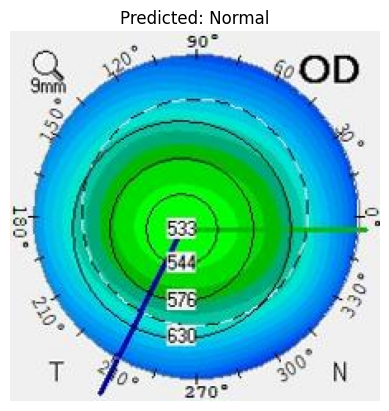


📌 Randomly picked image from Keratoconus: KCN_41_Sag_A.jpg
Prediction: Suspect
Probabilities:
  Normal: 0.1867
  Keratoconus: 0.4036
  Suspect: 0.4097


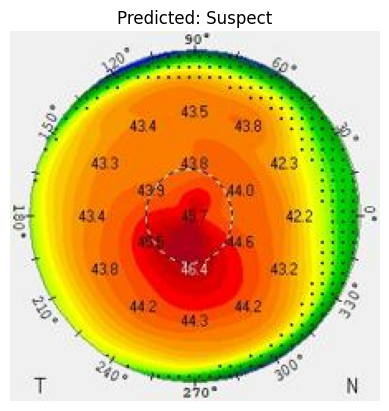


📌 Randomly picked image from Suspect: SUSP_17_Sag_A.jpg
Prediction: Suspect
Probabilities:
  Normal: 0.2305
  Keratoconus: 0.0311
  Suspect: 0.7384


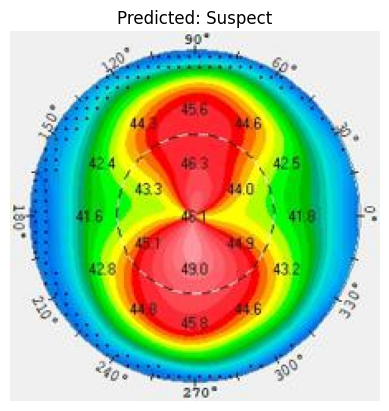

In [ ]:
import random
import glob
import os
import cv2
import matplotlib.pyplot as plt


def predict_random_image(class_folder, class_name):
    # Get all valid images by searching recursively through subdirectories
    img_paths = glob.glob(os.path.join(class_folder, "**", "*"), recursive=True)
    img_paths = [p for p in img_paths if p.lower().endswith((".jpg",".jpeg",".png"))]

    if not img_paths:
        print(f"No images found in {class_folder}")
        return


    sample_img = random.choice(img_paths)

    feats = extract_features(sample_img).reshape(1, -1)
    feature_scaled = scaler.transform(feats)
    feature_pca = pca.transform(feature_scaled)

    pred_class = final_model.predict(feature_pca)[0]
    probas = final_model.predict_proba(feature_pca)[0]

    print(f"\n📌 Randomly picked image from {class_name}: {os.path.basename(sample_img)}")
    print("Prediction:", classes[pred_class])
    print("Probabilities:")
    for c, p in zip(classes, probas):
        print(f"  {c}: {p:.4f}")

    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {classes[pred_class]}")
    plt.show()



# Define the base directory for the test set
base_test_dir = "/content/keratoconus_dataset/Independent Test Set/Independent Test Set"

# Call the function for a random "Normal" image
predict_random_image(os.path.join(base_test_dir, "Normal"), "Normal")

# Call the function for a random "Keratoconus" image
predict_random_image(os.path.join(base_test_dir, "Keratoconus"), "Keratoconus")

# Call the function for a random "Suspect" image
predict_random_image(os.path.join(base_test_dir, "Suspect"), "Suspect")